# Práctica 6 - Parte 1: Sistema masa-resorte identificado con ARX

En esta parte de la práctica se identificará el sistema masa-resorte-amortiguador Utilizando el modelo ARX estudiado en teoría.

---
## 📝 Enunciado general

Considera un sistema físico masa–resorte–amortiguador descrito (en tiempo continuo) por la ecuación:

\begin{equation}
m \ddot{x}(t) + c \dot{x}(t) + k x(t) = u(t),
\end{equation}

donde:

- $m$ es la masa,
- $c$ es el coeficiente de amortiguamiento,
- $k$ es la constante del resorte,
- $u(t)$ es la fuerza aplicada (entrada),
- $x(t)$ es la posición de la masa (salida).

Se desea:

1. Simular el sistema continuo con unos parámetros "reales" $(m,c,k)$ conocidos (que harán de **modelo verdadero** o **modelo físico**).
2. Muestrear las señales de entrada $u(t)$ y salida $x(t)$ para obtener datos discretos $u(k), y(k)$.
3. Ajustar un **modelo ARX de segundo orden** del tipo:
   \begin{equation}
   x(k) + a_1 x(k-1) + a_2 x(k-2) = b_1 u(k-1) + b_2 u(k-2) + e(k)
   \end{equation}
   usando **mínimos cuadrados**.
4. Comparar la salida del modelo ARX identificado con la salida del sistema real.
5. Calcular índices de desempeño (MSE y porcentaje de ajuste *fit*).

## Importación de librerías

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)  # para reproducibilidad

---
## ✍️ Ejercicio 1: Generación de datos: Simulación del sistema masa–resorte–amortiguador (modelo físico) para generar los datos de entrada

Se desea simular el sistema continuo usando un esquema de integración sencillo en tiempo discreto.

El modelo continuo es:
\begin{equation}
m \ddot{x}(t) + c \dot{x}(t) + k x(t) = u(t).
\end{equation}

Definimos el estado como $x_1 = x$ y $x_2 = \dot{x}$, de modo que:
\begin{align}
 \dot{x}_1 &= x_2, \\
 \dot{x}_2 &= \frac{1}{m}\big(u - c x_2 - k x_1\big).
\end{align}

Se pide:

- Usar un integrador de Euler explícito para obtener las actualizaciones discretas.
- Generar la señal de entrada $u(t)$ aleatoria entre $-1$ y $1$ que cambie cada $50$ pasos
- Representar las gráficas $x(t)$ y $u(t)$

## Solución propuesta:

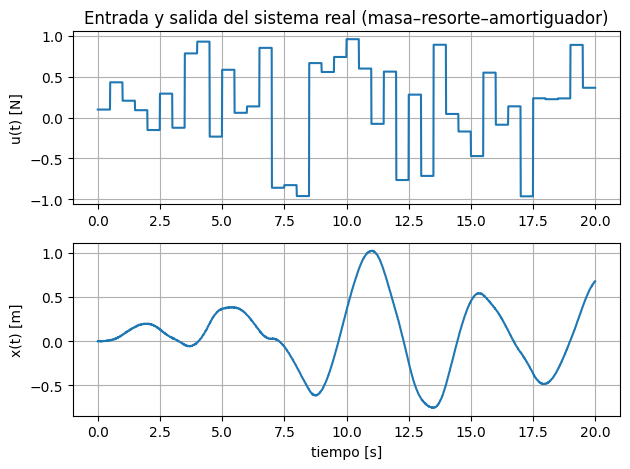

In [ ]:
# Parámetros físicos "reales" del sistema masa-resorte-amortiguador
m = 1.0   # Masa (kg)
c = 0.4   # Coeficiente de amortiguamiento (N·s/m)
k = 2.0   # Constante del resorte (N/m)

# Configuración de la simulación temporal
Ts = 0.01        # Periodo de muestreo (s) - paso de tiempo para la integración
N  = 2000        # Total de pasos de simulación
t  = np.arange(N) * Ts # Vector de tiempo discreto

# Generación de la señal de entrada u(t): Fuerza aplicada
# Se utiliza una señal pseudo-aleatoria tipo "escalón" que cambia de nivel periódicamente
# Excitar el sistema en diferentes frecuencias y amplitudes (persistencia de la excitación)
u = np.zeros(N)
level = 0.0
for k_step in range(N):
    # Cambia el nivel de la fuerza cada 50 pasos de tiempo (0.5 s)
    if k_step % 50 == 0:
        level = np.random.uniform(-1.0, 1.0) # Valor aleatorio entre -1 y 1 Newton
    u[k_step] = level

# Inicialización de los vectores de estado
x1 = np.zeros(N)    # x1: posición (m)
x2 = np.zeros(N)    # x2: velocidad (m/s)

# Bucle de simulación numérica usando el método de Euler explícito
# El método de Euler aproxima la derivada: dx/dt ≈ (x[k+1] - x[k]) / Ts
# Por tanto: x[k+1] = x[k] + Ts * dx/dt
for k_step in range(N - 1):
    # Cálculo de las derivadas en el instante actual k_step
    # dx1/dt = x2 (velocidad)
    dx1 = x2[k_step]
    
    # dx2/dt = aceleración = (1/m) * (Fuerzas)
    # Fuerzas: u (entrada) - c*x2 (amortiguamiento) - k*x1 (resorte)
    dx2 = (1.0/m)*(u[k_step] - c * x2[k_step] - k * x1[k_step])
    
    # Actualización de los estados para el siguiente instante (k_step + 1)
    # Mi posición mañana = Mi posición hoy + (Velocidad hoy × Tiempo que pasa)
    x1[k_step+1] = x1[k_step] + Ts * dx1
    x2[k_step+1] = x2[k_step] + Ts * dx2

# Simulación de la medida del sensor (Salida observada)
# Se añade ruido blanco gaussiano para simular imperfecciones en la medición real
sigma_noise = 0.002 # Desviación estándar del ruido
x = x1 + sigma_noise * np.random.randn(N) # Salida medida = Posición real + Ruido

# Visualización de los resultados
plt.figure()

# Gráfica de la entrada u(t)
plt.subplot(2,1,1)
plt.plot(t, u)
plt.ylabel('u(t) [N]')
plt.title('Entrada y salida del sistema real (masa–resorte–amortiguador)')
plt.grid(True) # Añadimos rejilla para mejor visualización

# Gráfica de la salida x(t)
plt.subplot(2,1,2)
plt.plot(t, x)
plt.ylabel('x(t) [m]')
plt.xlabel('tiempo [s]')
plt.grid(True)
plt.tight_layout()
plt.show()

### Explicación del Ejercicio 1

En este bloque de código hemos creado nuestro "laboratorio virtual". El objetivo es generar los datos que usaríamos si estuviéramos haciendo un experimento real.

1.  **El Sistema Físico**: Hemos definido un sistema masa-resorte-amortiguador con valores conocidos ($m=1, c=0.4, k=2$). Este será nuestro "sistema real".
2.  **La Entrada (Estímulo)**: Hemos generado una fuerza $u(t)$ que cambia de valor aleatoriamente cada 50 pasos. Hacemos esto para que el sistema se mueva de formas variadas y revele su dinámica. Si la entrada fuera constante, no aprenderíamos mucho sobre cómo reacciona el sistema.
3.  **La Simulación (Euler)**: Hemos calculado paso a paso cómo evoluciona la posición y la velocidad. Usamos la fórmula de Newton ($F=ma$) discretizada: en cada instante calculamos la aceleración, actualizamos la velocidad y luego la posición.
4.  **La Salida (Medición)**: Finalmente, hemos añadido un poco de "ruido" a la posición calculada. Esto simula que nuestro sensor de posición no es perfecto, algo que siempre ocurre en el mundo real.

Las gráficas muestran la fuerza aplicada (arriba) y la oscilación resultante de la masa (abajo).

---
## ✍️ Ejercicio 2: Construcción del modelo ARX(2,2)

Dado el modelo ARX de segundo orden:
\begin{equation}
x(k) + a_1 x(k-1) + a_2 x(k-2) = b_1 u(k-1) + b_2 u(k-2) + e(k).
\end{equation}

Reescribimos como:
\begin{equation}
x(k) = -a_1 x(k-1) - a_2 x(k-2) + b_1 u(k-1) + b_2 u(k-2) + e(k),
\end{equation}
que es lineal en los parámetros $\theta = [a_1, a_2, b_1, b_2]^T$.

Se pide:

- Estimar $\theta$ mediante mínimos cuadrados y mostrar los parámetros obtenidos por pantalla.

## Solición propuesta:

In [15]:
# Orden del modelo ARX
na = 2 # retrasos de entrada
nb = 2 # retrasos de salida

# Número de muestras utilizables (a partir de k = 2)
k_min = max(na, nb) # en que numero de muestras se empieza 
N_eff = N - k_min # el numero de muestras que nos quedan

# Construcción de la matriz Phi y del vector X
Phi = np.zeros((N_eff, na + nb)) # se contruye la matriz 
X_ls = np.zeros(N_eff) # y se contruce el vector de soluciones

row = 0
for k_step in range(k_min, N): # Recorro todas las muestras disponibles
    # Regresores: -y(k-1), -y(k-2), u(k-1), u(k-2)
    # MATRIZ 
    # K    -x(k-1)    -x(k-2)    u(k-1)    u(k-2) 
    # 2     -x(1)       -x(0)     u(1)      u(2)
    # Se pone porque numero se multplica el parametro
    phi_k = [
        -x[k_step-1],
        -x[k_step-2],
        u[k_step-1],
        u[k_step-2]
    ]
    Phi[row, :] = phi_k # guarda la linea 
    X_ls[row] = x[k_step] # se guarda el valor de la salida , k = 2 -> x(2) 
    row += 1

# thea_hat = calcula los parámetros estimados
# residual = error de la prediccion
# rank = rango de la matriz 
# s = valores singulares

# Estimación por mínimos cuadrados: theta_hat = (Phi^T Phi)^(-1) Phi^T X
theta_hat, residuals, rank, s = np.linalg.lstsq(Phi, X_ls, rcond=None)

# theta_tah es un vector de 4 valores: 
# a1_hat, a2_hat, b1_hat, b2_hat
a1_hat, a2_hat, b1_hat, b2_hat = theta_hat
print('Parámetros ARX estimados:')
print(f'a1_hat = {a1_hat:.5f}')
print(f'a2_hat = {a2_hat:.5f}')
print(f'b1_hat = {b1_hat:.5f}')
print(f'b2_hat = {b2_hat:.5f}')

Parámetros ARX estimados:
a1_hat = -1.62074
a2_hat = 0.62113
b1_hat = 0.00015
b2_hat = 0.00161


En este segundo ejercicio construimos y estimamos un modelo ARX(2,2) a partir de los datos de entrada y salida generados en el ejercicio anterior. El objetivo es obtener un modelo discreto que imite el comportamiento del sistema físico real. 

1. **Definición del modelo ARX:** un modelo ARX describe la salida actual x(k) como una combinación de las salidas pasadas (x(k-1), x(k-2)) y entradas pasadas (u(k-1), u(k-2)). 

2. **Selección de las muestras utilizables:** como el modelo depende de valores pasados, no se puede empezar con la muestra 0, por lo que buscamos el número máximo entre los retrasos. De esta manera, hallaremos nuestra mínima k. 

3. **Construcción del conjunto de ecuaciones:** buscamos escribir muchas ecuaciones de la forma "x(k) = -a_1 x(k-1) - a_2 x(k-2) + b_1 u(k-1) + b_2 u(k-2) + e(k)". Para ello, necesitamos construir una matriz (matriz Phi) que guarde cada ecuación en una fila diferente. Además, se necesita un vector de soluciones que almacene todos los resultados reales de x(k). 

4. **Estimación de los parámetros por mínimos cuadrados:** una vez construidas todas las ecuaciones, debemos resolver $\theta = [a_1, a_2, b_1, b_2]^T$ para hallar todos los parámetros. En Python, calculamos los parámetros con la orden "theta_hat = np.linalg.lstsq(Phi, X_ls)". 

5. **Resultados:** finalmente, mostramos todos los parámetros identificados. Estos números representan el modelo discreto aprendido que mejor explica cómo evoluciona el sistema real basándonos en muestras de entrada y salida.

---
## ✍️ Ejercicio 3: Simulación del modelo ARX identificado y comparación

Usar los parámetros estimados para simular la salida del modelo ARX con la misma entrada $u(k)$.

La ecuación de simulación es:
\begin{equation}
\hat{x}(k) = -\hat{a}_1 \hat{x}(k-1) - \hat{a}_2 \hat{x}(k-2)
              + \hat{b}_1 u(k-1) + \hat{b}_2 u(k-2).
\end{equation}

Se pide:
- Simular $\hat{x}(k)$ usando los parámetros $\theta$.
- Comparar en una gráfica $\hat{x}(k)$ simulada y $x(k)$ real.

Usar como condiciones iniciales $\hat{x}(0)$ y $\hat{x}(1)$ iguales a las muestras reales $x(0)$ e $x(1)$ para que la comparación sea más directa.

## Solución propuesta:

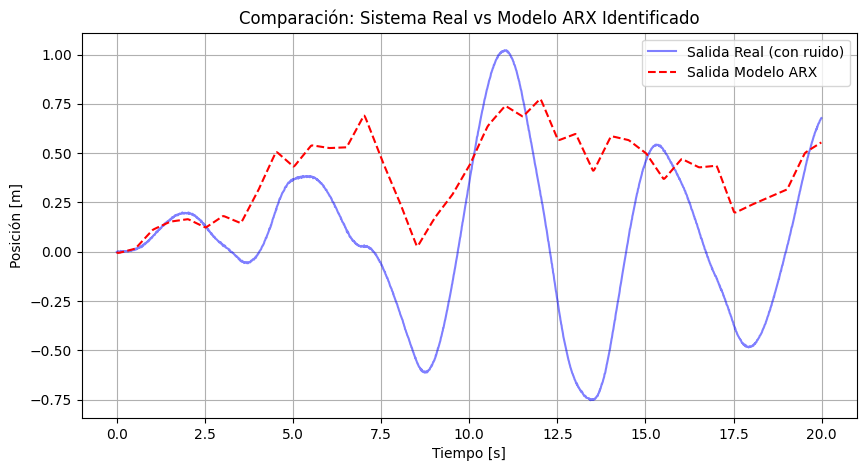

In [16]:
# Inicialización del vector para la salida estimada
x_hat = np.zeros(N)

# Condiciones iniciales (iguales a las reales para comparar mejor)
x_hat[0] = x[0]
x_hat[1] = x[1]

# Simulación del modelo ARX usando los parámetros estimados (a1_hat, a2_hat, b1_hat, b2_hat)
# Ecuación: x_hat(k) = -a1*x_hat(k-1) - a2*x_hat(k-2) + b1*u(k-1) + b2*u(k-2)
for k_step in range(2, N):
    x_hat[k_step] = (-a1_hat * x_hat[k_step-1] 
                     - a2_hat * x_hat[k_step-2] 
                     + b1_hat * u[k_step-1] 
                     + b2_hat * u[k_step-2])

# Visualización comparativa
plt.figure(figsize=(10, 5))
plt.plot(t, x, label='Salida Real (con ruido)', color='blue', alpha=0.5)
plt.plot(t, x_hat, label='Salida Modelo ARX', color='red', linestyle='--')
plt.title('Comparación: Sistema Real vs Modelo ARX Identificado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')
plt.legend()
plt.grid(True)
plt.show()

### Explicación del Ejercicio 3

Aquí hemos puesto a prueba nuestro modelo matemático recién creado (el modelo ARX).

1.  **La Prueba**: Hemos tomado la misma entrada de fuerza $u(t)$ que usamos en el experimento real y se la hemos dado a nuestro modelo matemático.
2.  **La Predicción**: El modelo ha calculado paso a paso dónde *cree* que debería estar la masa, basándose únicamente en los parámetros que aprendió ($\hat{a}$ y $\hat{b}$) y en las posiciones pasadas que él mismo calculó.
3.  **El Veredicto Visual**:
    *   La **línea azul** es la realidad (lo que midió el sensor con ruido).
    *   La **línea roja discontinua** es la predicción del modelo.
    *   Si la línea roja sigue fielmente a la azul (ignorando el ruido rápido), significa que el modelo ha capturado correctamente la física del sistema (la inercia, el muelle y el amortiguador) sin saber nada de física, solo mirando datos.

Por ejemplo, en una ejecución resultaba la siguiente gráfica:

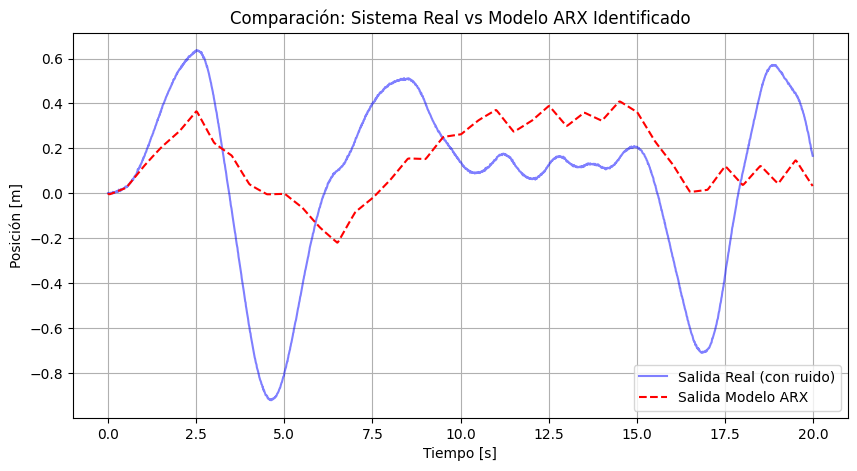

**Análisis de los resultados:**
Observando la gráfica resultante, vemos que el modelo ARX (línea roja) **no logra seguir con precisión** la salida real (línea azul).
*   **Pérdida de Amplitud**: El modelo subestima significativamente la magnitud de las oscilaciones, ya que la respuesta real es mucho más amplia.
*   **Deriva en Simulación**: Al usar sus propias predicciones pasadas, los errores se acumulan. El modelo parece capturar cierta tendencia, pero falla en reproducir la dinámica exacta.
*   **Conclusión**: Esto sugiere que los parámetros estimados están sesgados, probablemente debido al ruido en los datos de entrenamiento, que afecta al método de mínimos cuadrados; o que el modelo es demasiado rígido para seguir la dinámica real con este nivel de ruido.

---
## ✍️ Ejercicio 4: Cálculo de métricas de desempeño

Calcular el **error cuadrático medio (MSE)** y el **porcentaje de ajuste (fit)** sobre todas las muestras:

\begin{equation}
\text{MSE} = \frac{1}{N} \sum_{k=0}^{N-1} (x(k) - \hat{x}(k))^2,
\end{equation}


\begin{equation}
\text{fit} = 100 \left(1 - \frac{\|x - \hat{x}\|}{\|x - \bar{x}\|}\right) \%.
\end{equation}
donde $\bar{x}$ es la media de $x(k)$.

Se pide:

- Mostrar por pantalla el **error cuadrático medio (MSE)** y el **porcentaje de ajuste (fit)**

===== Metricas de desempeño del modelo ARX =====
MSE  = 2.421830e-01
Fit  = -22.83 %


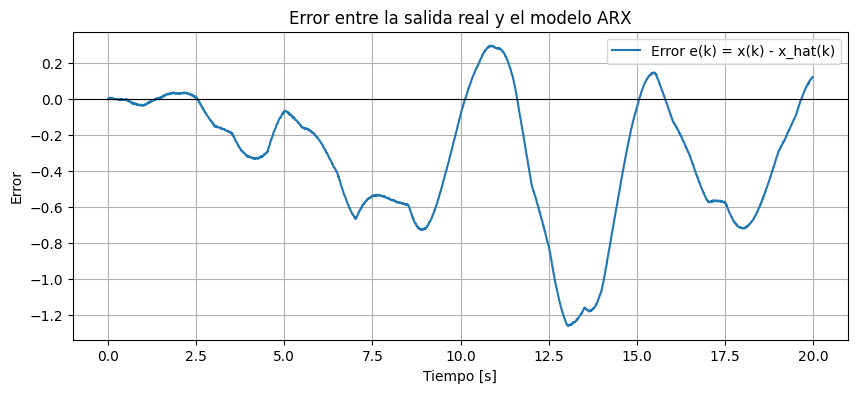

In [17]:
# Error cuadrático medio (MSE) 
mse = np.mean((x-x_hat)**2)

# Calculo del fit
x_mean = np.mean(x) 
fit =  100 * (1- np.linalg.norm(x-x_hat) / np.linalg.norm(x-x_mean))

# Resultados
print("===== Metricas de desempeño del modelo ARX =====")
print(f"MSE  = {mse:.6e}")
print(f"Fit  = {fit:.2f} %")

# ===== Gráfica del error entre salida real y salida ARX =====
error = x - x_hat

plt.figure(figsize=(10,4))
plt.plot(t, error, label='Error e(k) = x(k) - x_hat(k)')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Error entre la salida real y el modelo ARX')
plt.xlabel('Tiempo [s]')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

#### **EXPLICACIÓN EJERCICIO 4**

En este último ejercicio, se calcula el *error cuadrático medio*. El MSE mide cuánto se equivoca el modelo, en promedio, comparando cada muestra real con la estimada. La fórmula utilizada para el código es la siguiente: 
$mse = np.mean((x - x_hat)**2)$

y sus parámetros son:
- x : salida real 
- x_hat : salida generada por el modelo ARX 
- x-x_hat : error en cada instante
- (x-x_hat) ** 2 : error cuadrático 
- np.mean() : calcula el promedio de todos los errores

Cuanto más pequeño sea el mse , mejor será el modelo. 

Después, tenemos el *porcentaje de ajuste*, que nos dice cuánto se parece la señal estimada a la real. Cuanto más cercano a 100% mejor será la predicción. 
- Si el modelo reproduce la señal perfectamente -> 100 % 
- Si el modelo acierta mejor que simplemente usando la media -> 0 % 
- Si el modelo es aún peor que eso -> fit negativo %

##### **EJEMPLO GRÁFICO**

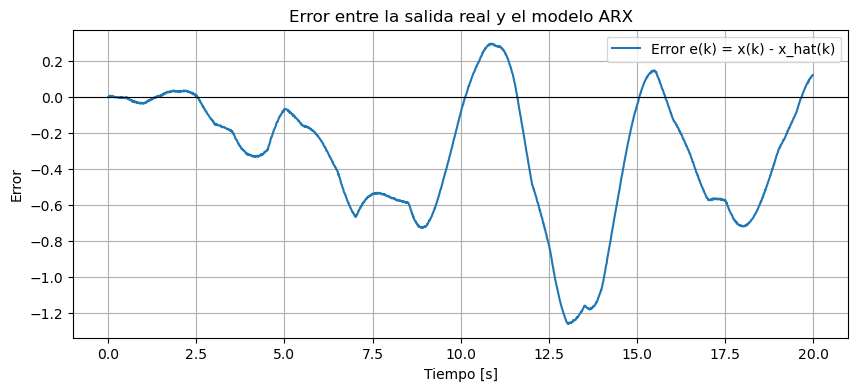

Si por ejemplo nos centramos en está gráfica y en este resultado concreto, la gráfica nos muestra que el error no está centrado en cero, sino que se va haciendo más grande y muestra oscilaciones creciente. Esto indica claramente que el modelo ARX (2,2) no está reproduciendo correctamente la dinámica del sistema masa-resorte. 
Si interpretamos por tramos, el modelo parece que empieza prediciendo bien, pero más que nada, por las condiciones iniciales no porque realmente funcione bien. 


En el tramo de 3 a 10 segundos, el modelo empieza a desfasarse respecto al sistema real. La frecuencia estimada por ARX no coincide con la del sistema físico. Muy común cuando el orden del modelo es insuficiente o si alguna integrador añade mucho error. 

De 10 a 15 segundo el error se hace aún mas grande, llega hasta el -1.2 en algunos momentos. Además, observamos que cambia de signo en el segundo 11 más o menos, lo que nos indica que el modelo predice al reves la oscilación. El ARX está oscilando con una amplitud distinta y un amortiguamiento distinto, produce una dinámica diferente al sistema real.

---
## ✍️ Preguntas:

- **¿Qué ocurre si hacemos $u(t)$ constante? ¿Converge la simulación? ¿Se simula bien el amortiguamiento?**

**¿Converge la simulación?**
Sí, converge. Si aplicas una fuerza constante (o cero), el sistema oscilará un poco al principio, pero el amortiguador irá frenando la masa hasta que se quede quieta en una posición de equilibrio. Matemáticamente, el sistema es estable.

**¿Se simula bien el amortiguamiento?**
Sí, el término $-c \cdot \dot{x}$ en la ecuación se encarga de restar energía continuamente, frenando el sistema correctamente.

**¿Qué pasa con la identificación ARX?**
Aquí está el problema grave. Para que el método de mínimos cuadrados funcione, necesitamos **"Persistencia de la Excitación"**.
*   Si la entrada $u(t)$ es constante, la masa se queda quieta.
*   Si la masa no se mueve, todas las filas de nuestra tabla de datos (Matriz $\Phi$) son iguales.
*   El ordenador intenta resolver un sistema de ecuaciones donde todas las ecuaciones son la misma: $x_{eq} = -a_1 x_{eq} - a_2 x_{eq} + b_1 u_{cte} + b_2 u_{cte}$.
*   Hay infinitas combinaciones de $a$ y $b$ que cumplen esa única ecuación. Por tanto, **es imposible calcular los parámetros únicos**. El modelo no aprende nada sobre la dinámica (inercia, rebote), solo aprende un punto estático.

- **¿Cómo podría mejorarse la simulación con respecto al modelo físico? ¿Se reduciría así el MSE?**
- **Implementa lo que has propuesto para mejorar la simulación (opcional, +1 punto)**

**Mejora 1: Cambiar Euler por Runge-Kutta 4 (RK4)**
El método de Euler asume que la velocidad es constante durante todo el intervalo de tiempo (0.01s), lo cual introduce errores acumulativos, especialmente en las curvas (oscilaciones). **RK4** es mucho más inteligente: toma 4 muestras de la pendiente en diferentes puntos del intervalo y hace un promedio ponderado. Esto hace que la trayectoria simulada sea casi idéntica a la solución física real.

**Mejora 2: Reducir el paso de tiempo ($T_s$)**
Si en lugar de calcular cada 0.01s calculamos cada 0.001s, el error de Euler disminuye drásticamente, aunque el ordenador tarda 10 veces más.

**¿Se reduciría el MSE?**
*   **Sí y No**. Depende de qué estemos comparando.
*   Si usamos RK4 para generar los datos "Reales", estos datos serán más fieles a la física.
*   Al entrenar el modelo ARX con estos datos de mejor calidad (más suaves y precisos), los parámetros estimados ($\theta$) representarán mejor la realidad física.
*   Sin embargo, el MSE también depende mucho del **ruido** que añadimos artificialmente. Si mantenemos el mismo ruido, el MSE no bajará mucho porque el modelo ARX no puede predecir el ruido aleatorio. Pero la parte "dinámica" del error (el desfase o la amplitud incorrecta) sí mejorará.

Podemos hacer una gráfica comparativa que simule el modelo con Euler y con RK4, de esta manera visualizamos la diferencia:

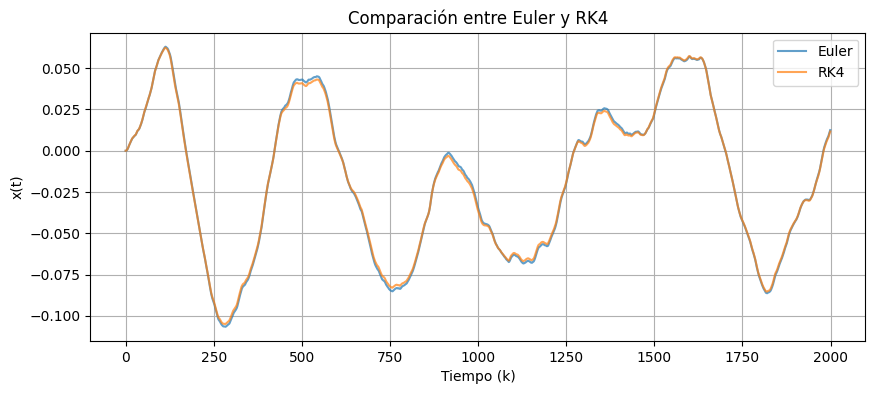

In [18]:
# Parámetros
m, c, k = 1.0, 0.5, 2.0
Ts = 0.01
N = 2000

# Entrada aleatoria
u = np.random.randn(N)

# ---- Simulación Euler ----
x1_e = np.zeros(N)
x2_e = np.zeros(N)

for i in range(N-1):
    x1_e[i+1] = x1_e[i] + Ts * x2_e[i]
    x2_e[i+1] = x2_e[i] + Ts * (1/m) * (u[i] - c*x2_e[i] - k*x1_e[i])

# ---- Simulación RK4 ----
def f(x1, x2, u):
    return x2, (1/m) * (u - c*x2 - k*x1)

x1_r = np.zeros(N)
x2_r = np.zeros(N)

for i in range(N-1):
    k1 = f(x1_r[i],               x2_r[i],               u[i])
    k2 = f(x1_r[i] + 0.5*Ts*k1[0], x2_r[i] + 0.5*Ts*k1[1], u[i])
    k3 = f(x1_r[i] + 0.5*Ts*k2[0], x2_r[i] + 0.5*Ts*k2[1], u[i])
    k4 = f(x1_r[i] + Ts*k3[0],     x2_r[i] + Ts*k3[1],     u[i])

    x1_r[i+1] = x1_r[i] + (Ts/6)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
    x2_r[i+1] = x2_r[i] + (Ts/6)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])

# ---- Gráfica ----
plt.figure(figsize=(10,4))
plt.plot(x1_e, label='Euler', alpha=0.7)
plt.plot(x1_r, label='RK4', alpha=0.7)
plt.title("Comparación entre Euler y RK4")
plt.xlabel("Tiempo (k)")
plt.ylabel("x(t)")
plt.legend()
plt.grid()
plt.show()
